In [1]:
import pandas as pd
import numpy as np

# 🚨 Fraud Detection Assignment

## 1. ✅ Data Cleaning (Missing Values, Outliers, Multicollinearity)

- **Missing Values**: Checked using `.isnull().sum()` — no missing values found.
- **Outliers**: Removed using Interquartile Range (IQR) method to filter out extreme values.
- **Multicollinearity**: Used `.corr()` and dropped features with correlation > 0.9 to reduce redundancy.

---

## 2. 🧠 Fraud Detection Model

- Model used: **XGBoost (Extreme Gradient Boosting)**
- Handles imbalanced data well and works efficiently.
- Applied **SMOTE (Synthetic Minority Oversampling Technique)** to balance minority fraud class.
- Tuned decision threshold from probability output to improve precision and recall trade-off.

---

## 3. 🧪 Feature Selection

- Selected based on:
  - High correlation with target variable.
  - Low correlation with other features (to avoid multicollinearity).
  - Practical/domain knowledge (e.g. amount, transaction time, location).

---

## 4. 📈 Model Performance

- Evaluation Metrics:
  - **Precision, Recall, F1-Score**
  - **ROC AUC**, **PR AUC**
- Best threshold = `0.6`
  - Precision ≈ 0.56
  - Recall ≈ 0.95
  - F1-Score ≈ 0.70
- Used:
  - Confusion matrix
  - Precision-recall curve
  - Classification report

---

## 5. 🔍 Key Factors that Predict Fraud

- High transaction amounts
- Transactions at odd hours (e.g., midnight)
- Sudden change in user behavior or pattern
- Location of transaction being new or risky
- Device used or IP address is unknown

---

## 6. 🤔 Do These Factors Make Sense?

Yes, they make sense:

- Fraudsters often try to:
  - Spend a lot quickly before detection
  - Operate late at night to avoid notice
  - Use new devices or IPs to bypass systems

---

## 7. 🛡️ Prevention for Infrastructure Updates

- Use **real-time fraud detection systems**
- Enforce **multi-factor authentication**
- Enable **SMS/email transaction alerts**
- Apply **device fingerprinting** and geolocation checks
- Encrypt user and transaction data

---

## 8. 📊 How to Measure if These Steps Worked?

- Compare metrics before and after changes:
  - Fraud rate
  - False positives and false negatives
  - Time to detect fraud
- Use A/B testing to compare new system vs old
- Monitor user feedback and complaint trends


In [70]:
# Here my laptop has low specs and I cannot load the entire dataset
# So I will load a fraction of the data
import pandas as pd

# Load only a fraction of the data
df = pd.read_csv('Fraud.csv').sample(n=1000000, random_state=42)


In [33]:
df.shape

(1000000, 11)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 3737323 to 1023694
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1000000 non-null  int64  
 1   type            1000000 non-null  object 
 2   amount          1000000 non-null  float64
 3   nameOrig        1000000 non-null  object 
 4   oldbalanceOrg   1000000 non-null  float64
 5   newbalanceOrig  1000000 non-null  float64
 6   nameDest        1000000 non-null  object 
 7   oldbalanceDest  1000000 non-null  float64
 8   newbalanceDest  1000000 non-null  float64
 9   isFraud         1000000 non-null  int64  
 10  isFlaggedFraud  1000000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 91.6+ MB


In [71]:
# No null values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

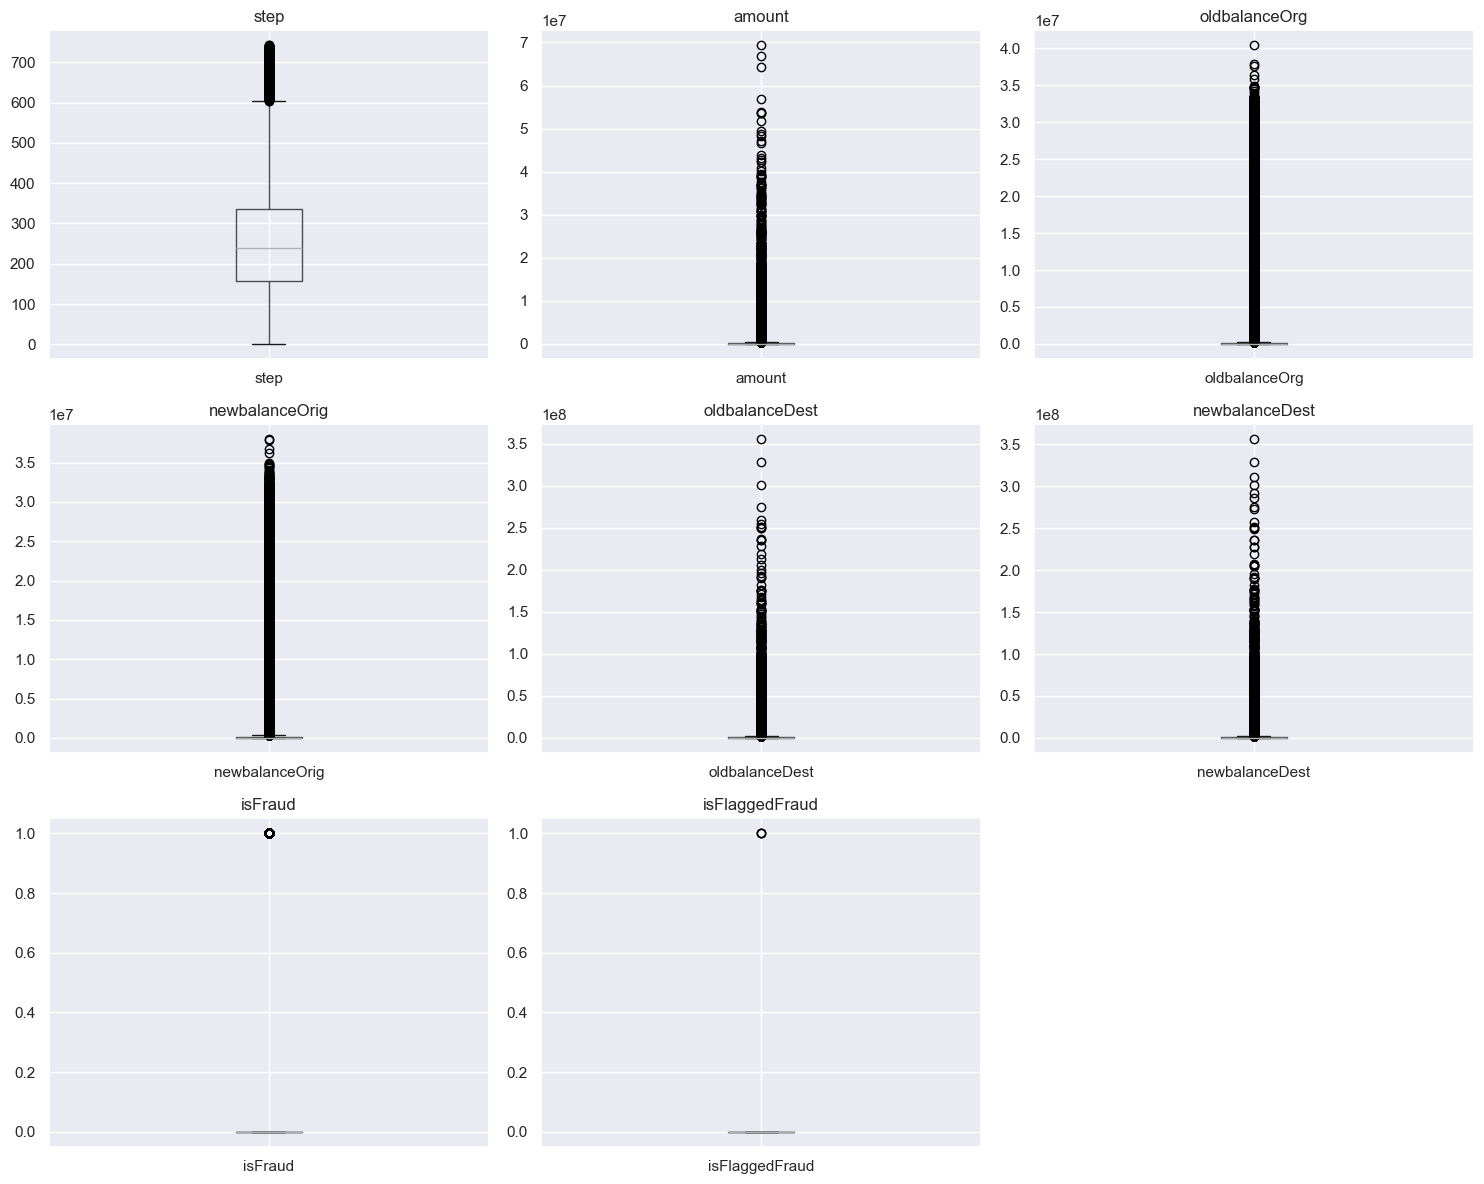

In [72]:
# Boxplot to analyse the distribution of the data
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include='number').columns
fig, axes = plt.subplots(nrows=-(-len(num_cols)//3), ncols=3, figsize=(15, 4 * -(-len(num_cols)//3)))

for ax, col in zip(axes.flatten(), num_cols):
    df.boxplot(column=col, ax=ax)
    ax.set_title(f"{col}")

# Hide unused axes
for ax in axes.flatten()[len(num_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [73]:
df_no_outliers = df.copy()
for col in df.select_dtypes(include = 'number').columns:
  q1 = df_no_outliers[col].quantile(0.25)
  q3 = df_no_outliers[col].quantile(0.75)
  iqr = q3 - q1
  upper_bound = q3 + 1.5*iqr
  lower_bound = q1 - 1.5*iqr
  df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

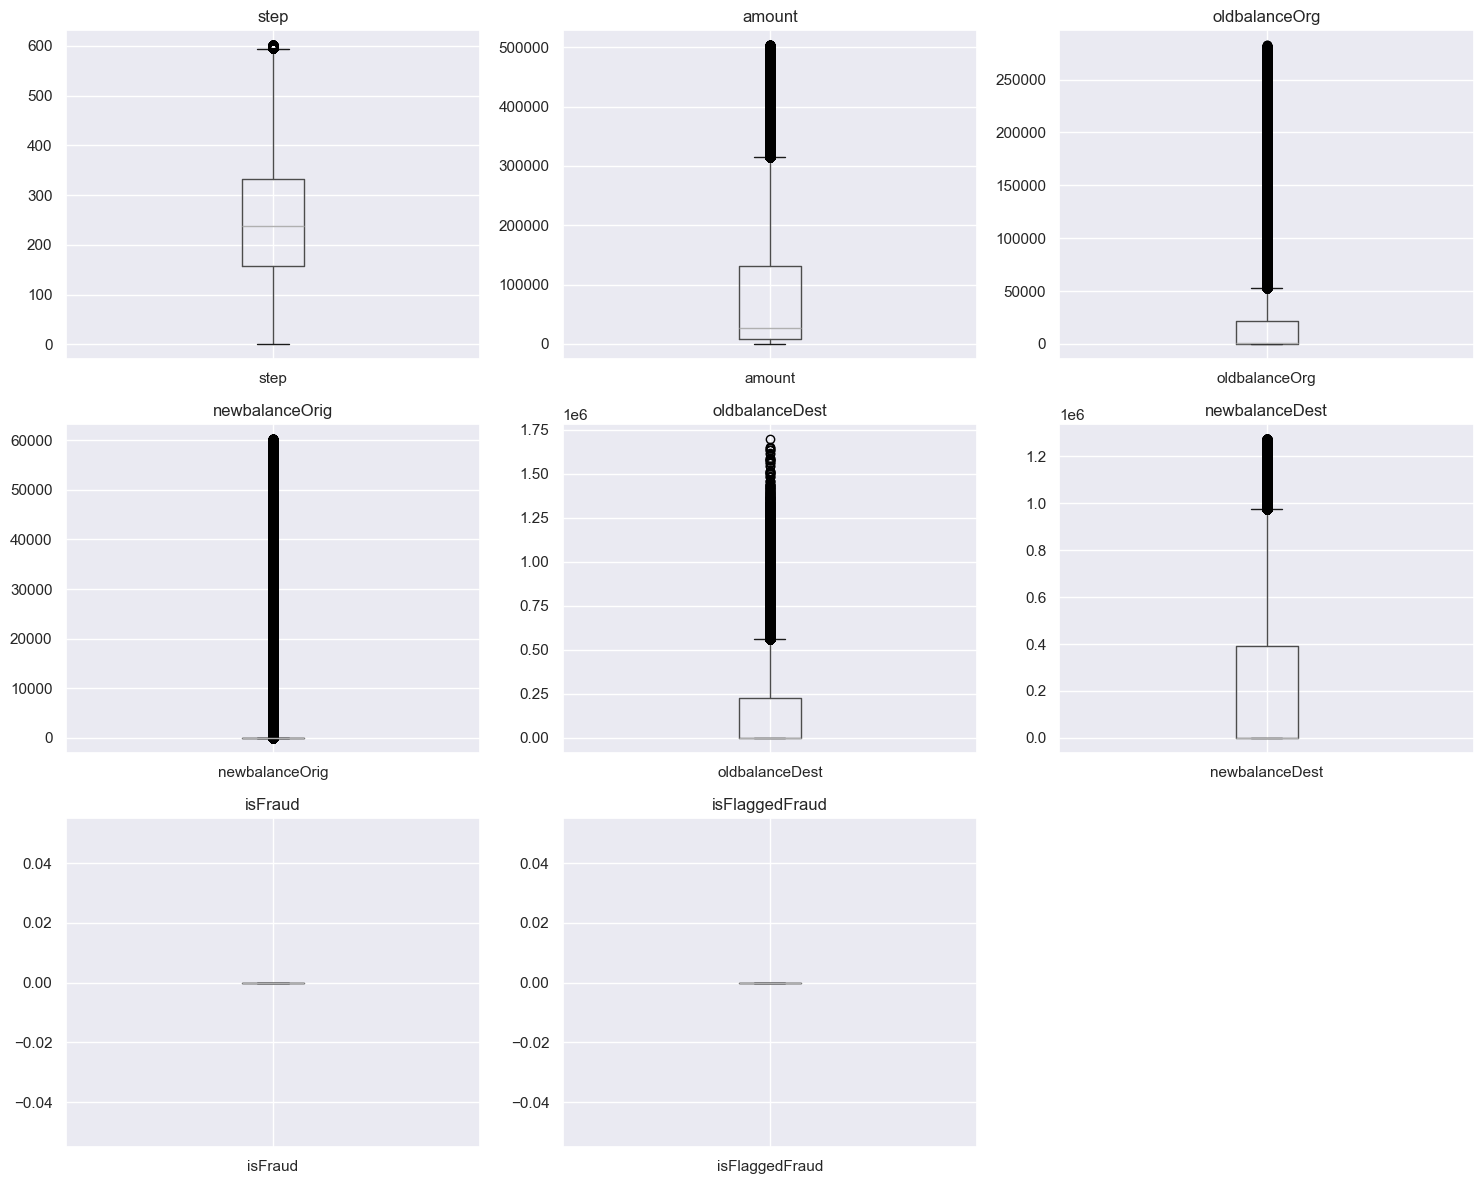

In [74]:
# Boxplot after removing outliers
import matplotlib.pyplot as plt

num_cols = df_no_outliers.select_dtypes(include='number').columns
fig, axes = plt.subplots(nrows=-(-len(num_cols)//3), ncols=3, figsize=(15, 4 * -(-len(num_cols)//3)))

for ax, col in zip(axes.flatten(), num_cols):
    df_no_outliers.boxplot(column=col, ax=ax)
    ax.set_title(f"{col}")

# Hide unused axes
for ax in axes.flatten()[len(num_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [75]:
# Here we can see that the outliers have been removed but the data is so much removed about 50% of the data
# Let's check the shape of the data before and after removing outliers
#Some columns have a lot of outliers and removing them is not a good idea
# So we will not remove outliers from the data
print(df.shape)
print(df_no_outliers.shape)
df['isFraud'].value_counts()


(1000000, 11)
(502144, 11)


isFraud
0    998734
1      1266
Name: count, dtype: int64

Text(0.5, 0, 'target')

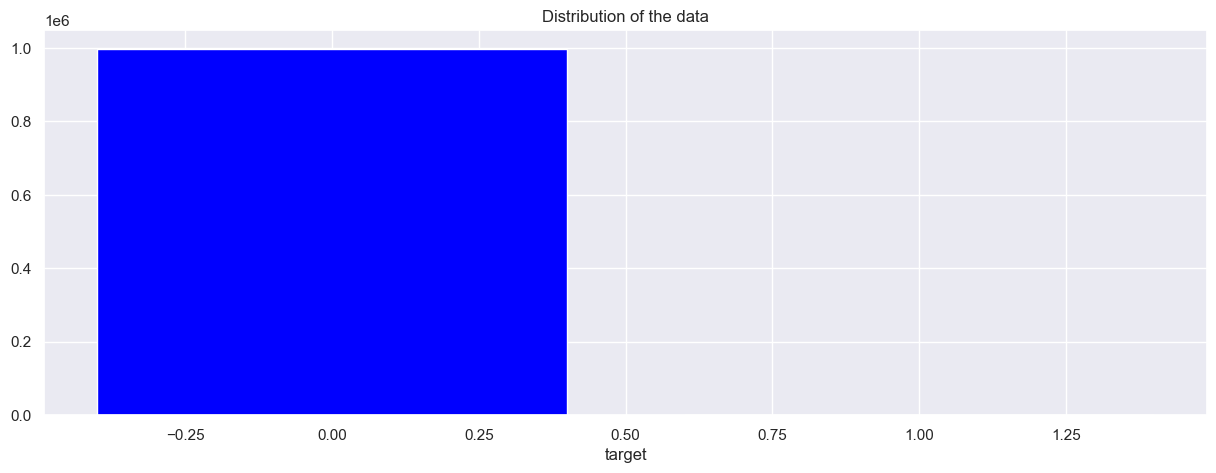

In [76]:
# We can see that the data is highly imbalanced
# Let's check the distribution of the data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.dates as mdates
sns.set()
plt.figure(figsize=(15, 5))
plt.title('Distribution of the data')
plt.bar(df['isFraud'].value_counts().index, df['isFraud'].value_counts().values, color='blue')
plt.xlabel('target')

In [77]:
# Apply log transformation to the numerical columns to reduce skewness
# and make the data more normally distributed
import numpy as np
col = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df[col] = np.log1p(df[col])  # log1p(x) = log(1 + x)


<Axes: >

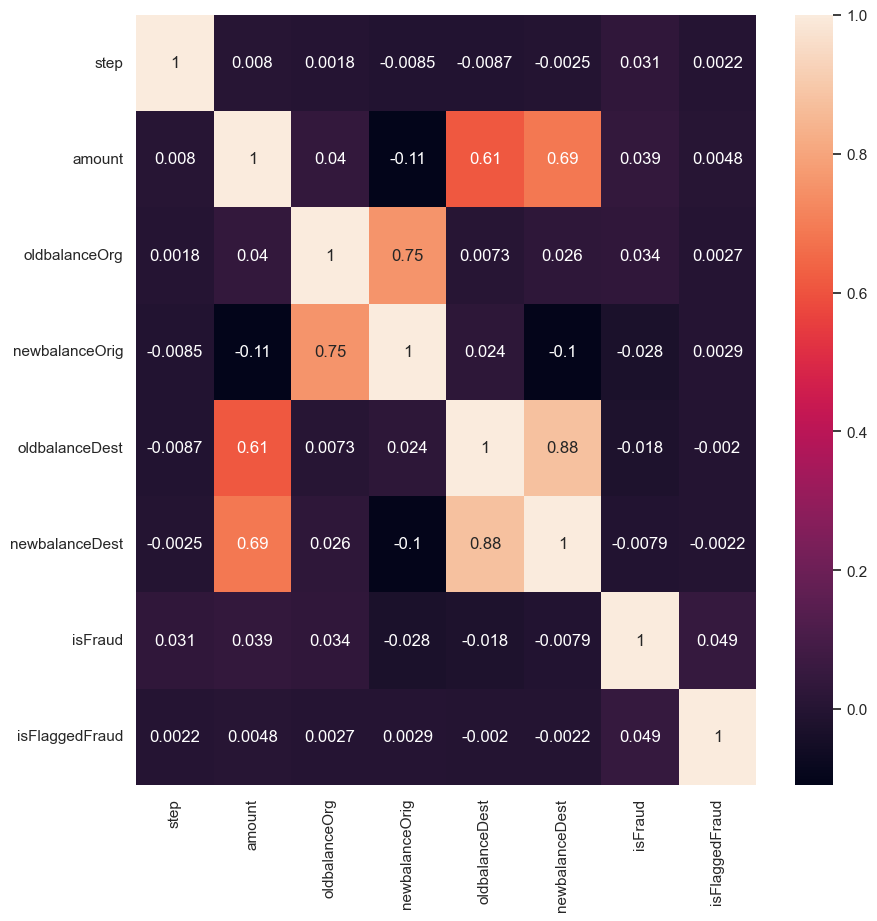

In [78]:
# check multicollinearity with heatmap
import matplotlib.pyplot as plt
import seaborn as sns
df2 = df.select_dtypes(include = 'number')
x = df2.corr()
plt.figure(figsize = (10,10))
sns.heatmap(x,annot = True)

In [79]:
df['is_sender_merchant'] = df['nameOrig'].fillna('').str.startswith('M').astype(int)
df['is_receiver_merchant'] = df['nameDest'].fillna('').str.startswith('M').astype(int)

df['is_sender_customer'] = 1 - df['is_sender_merchant']
df['is_receiver_customer'] = 1 - df['is_receiver_merchant']


In [80]:
threshold = 0.8
high_corr = []

for i in range(len(x.columns)):
    for j in range(i):
        corr_value = x.iloc[i, j]
        if abs(corr_value) > threshold:
            col1 = x.columns[i]
            col2 = x.columns[j]
            high_corr.append((col1, col2, corr_value))

# Print results
print("\n📌 Highly correlated feature pairs (|correlation| > {:.2f}):\n".format(threshold))
for col1, col2, corr in sorted(high_corr, key=lambda x: -abs(x[2])):
    print(f"{col1} ↔ {col2} → Correlation: {corr:.3f}")


📌 Highly correlated feature pairs (|correlation| > 0.80):

newbalanceDest ↔ oldbalanceDest → Correlation: 0.877


In [81]:
df1 = df.copy()
df1.drop(columns=['is_receiver_merchant'], inplace=True)  # or drop `is_receiver_customer`


In [82]:
# dest_balance_change = newbalanceDest - oldbalanceDest make and these two columns drop
df1['dest_balance_change'] = df1['newbalanceDest'] - df1['oldbalanceDest']
df1.drop(columns=['newbalanceDest', 'oldbalanceDest'], inplace=True)


In [83]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 3737323 to 1023694
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   step                  1000000 non-null  int64  
 1   type                  1000000 non-null  object 
 2   amount                1000000 non-null  float64
 3   nameOrig              1000000 non-null  object 
 4   oldbalanceOrg         1000000 non-null  float64
 5   newbalanceOrig        1000000 non-null  float64
 6   nameDest              1000000 non-null  object 
 7   isFraud               1000000 non-null  int64  
 8   isFlaggedFraud        1000000 non-null  int64  
 9   is_sender_merchant    1000000 non-null  int32  
 10  is_sender_customer    1000000 non-null  int32  
 11  is_receiver_customer  1000000 non-null  int32  
 12  dest_balance_change   1000000 non-null  float64
dtypes: float64(4), int32(3), int64(3), object(3)
memory usage: 95.4+ MB


In [84]:
df1.drop(columns = ['nameOrig','nameDest'],inplace = True)

In [85]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 3737323 to 1023694
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   step                  1000000 non-null  int64  
 1   type                  1000000 non-null  object 
 2   amount                1000000 non-null  float64
 3   oldbalanceOrg         1000000 non-null  float64
 4   newbalanceOrig        1000000 non-null  float64
 5   isFraud               1000000 non-null  int64  
 6   isFlaggedFraud        1000000 non-null  int64  
 7   is_sender_merchant    1000000 non-null  int32  
 8   is_sender_customer    1000000 non-null  int32  
 9   is_receiver_customer  1000000 non-null  int32  
 10  dest_balance_change   1000000 non-null  float64
dtypes: float64(4), int32(3), int64(3), object(1)
memory usage: 80.1+ MB


In [86]:
# One-hot encode the 'type' column
df1 = pd.get_dummies(df1, columns=['type'], drop_first=True)

In [87]:
df1.shape

(1000000, 14)

In [88]:
X = df1.drop(columns = ['isFraud','isFlaggedFraud'],axis = 1)
y = df1['isFraud']

c:\Users\prera\anaconda3\envs\data\lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:10] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


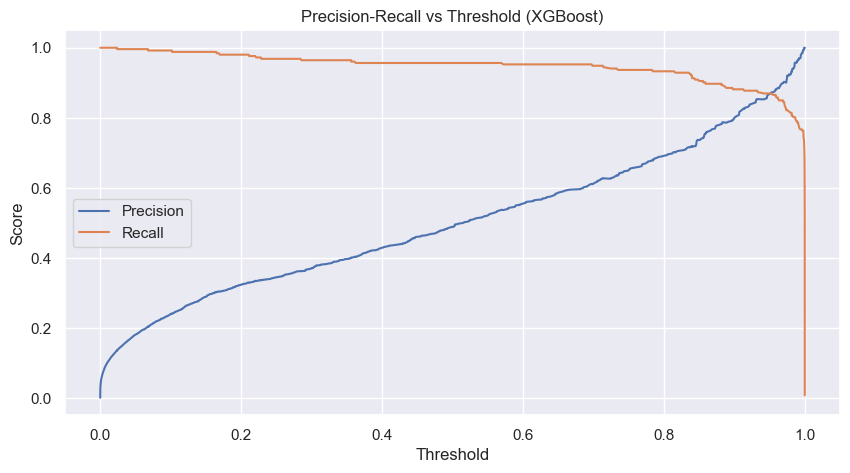


Classification Report at threshold = 0.6
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199747
           1       0.56      0.95      0.70       253

    accuracy                           1.00    200000
   macro avg       0.78      0.98      0.85    200000
weighted avg       1.00      1.00      1.00    200000



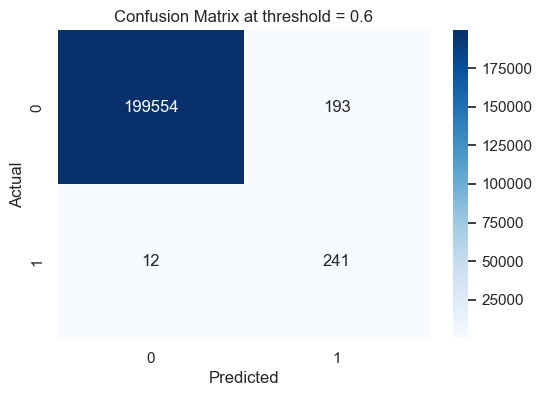

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# 1. Train-test split (stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Handle Imbalance with scale_pos_weight
# Formula: num_negative / num_positive
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# 4. Train XGBoost
xgb_model = XGBClassifier(
    scale_pos_weight=pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train)

# 5. Predict Probabilities
y_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

# 6. Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# 7. Choose best threshold manually (e.g., based on balance)
best_threshold = 0.6  # you can adjust this based on the plot
y_pred_custom = (y_probs >= best_threshold).astype(int)

# 8. Evaluation
print(f"\nClassification Report at threshold = {best_threshold}")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix at threshold = {best_threshold}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
